# import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# function

In [3]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

In [4]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [5]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [6]:
def plot_cm(cm_val, save=False,which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [7]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [8]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [9]:
def evaluate(param,split):
    model_path = "../SGD/models/param{}/sgd_model_{}.pkl".format(param,split)
    print(model_path)
    loaded_model = joblib.load(model_path)

    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, which="Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test,which="Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    
    coef(param,split)
    
    print("################# false predict ##################")
    fp = false_predict(y_val, y_pred_val, split)
    print(fp)
    
    return cm_val,cm_test,auc1,auc2

In [10]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [11]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

In [12]:
def false_predict(y_true, y_pred, split):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3_new/"
    # test_path =  "{}/test.csv".format(path)
    # test_data = pd.read_csv(test_path)
    valid_path = "{}/{}/val/val.csv".format(path,split)
    val_data = pd.read_csv(valid_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(val_data.loc[false_indices])
    return false_indices

In [13]:
def coef(param,split):
    model_path = "../SGD/models/param{}/sgd_model_{}.pkl".format(param,split)
    loaded_model = joblib.load(model_path)
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    
    feature_coef = loaded_model.coef_

    # print the feature importance
    for i, coef in enumerate(feature_coef):
        coef_abs = np.abs(coef)
        df = pd.DataFrame({'Variable':x_train.columns,
              'Coef':coef_abs}).sort_values('Coef', ascending=False)
        
        print(df)

# find param

In [13]:
def grid_search(x_train, y_train):
    # Define parameter grid
    param_grid = {'loss': ['modified_huber', 'log_loss'],
                  'penalty': ['l2', 'l1', 'elasticnet'],
                  'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                  'eta0': [0.001, 0.01, 0.1],
                  'max_iter': [1000, 2000, 5000],
                  'alpha': [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]}

    # Define SGD model
    model = SGDClassifier()

    # Define grid search object
    grid_search = GridSearchCV(model, param_grid)

    # Fit grid search object to the data
    grid_search.fit(x_train, y_train)

    # Print best parameter and score
    print('Best loss parameter:', grid_search.best_params_['loss'])
    print('Best penalty parameter:', grid_search.best_params_['penalty'])
    print('Best learning_rate parameter:', grid_search.best_params_['learning_rate'])
    print('Best eta0 parameter:', grid_search.best_params_['eta0'])
    print('Best max_iter parameter:', grid_search.best_params_['max_iter'])
    print('Best alpha parameter:', grid_search.best_params_['alpha'])
    print('Best score:', grid_search.best_score_)

In [14]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split1')
grid_search(x_train, y_train)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: modified_huber
Best penalty parameter: l1
Best learning_rate parameter: adaptive
Best eta0 parameter: 0.01
Best max_iter parameter: 1000
Best alpha parameter: 0.01
Best score: 0.9780458671763019


In [15]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split2')
grid_search(x_train, y_train)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: log_loss
Best penalty parameter: l2
Best learning_rate parameter: constant
Best eta0 parameter: 0.1
Best max_iter parameter: 5000
Best alpha parameter: 0.01
Best score: 0.9890587673196368


In [16]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split3')
grid_search(x_train, y_train)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: log_loss
Best penalty parameter: l1
Best learning_rate parameter: constant
Best eta0 parameter: 0.1
Best max_iter parameter: 1000
Best alpha parameter: 1e-06
Best score: 0.9802675585284281


In [17]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split4')
grid_search(x_train, y_train)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: log_loss
Best penalty parameter: l2
Best learning_rate parameter: optimal
Best eta0 parameter: 0.01
Best max_iter parameter: 1000
Best alpha parameter: 0.01
Best score: 0.9780697563306259


In [18]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split5')
grid_search(x_train, y_train)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: log_loss
Best penalty parameter: elasticnet
Best learning_rate parameter: constant
Best eta0 parameter: 0.1
Best max_iter parameter: 2000
Best alpha parameter: 0.01
Best score: 0.9736741519350215


# Set up all split

In [24]:
def train_param1(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='modified_huber', penalty='l1', learning_rate='adaptive', eta0=0.01, max_iter=1000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param1/sgd_model_{}.pkl".format(split))

In [25]:
def train_param2(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='log_loss', penalty='l2', learning_rate='constant', eta0=0.1, max_iter=5000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param2/sgd_model_{}.pkl".format(split))

In [26]:
def train_param3(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate='constant', eta0=0.1, max_iter=1000, alpha=1e-06)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param3/sgd_model_{}.pkl".format(split))

In [27]:
def train_param4(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='log_loss', penalty='l2', learning_rate='optimal', eta0=0.01, max_iter=1000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param4/sgd_model_{}.pkl".format(split))

In [28]:
def train_param5(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='log_loss', penalty='elasticnet', learning_rate='constant', eta0=0.1, max_iter=2000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param5/sgd_model_{}.pkl".format(split))

# Parameter1

## split1

In [29]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [30]:
train_param1(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param1/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.306647
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


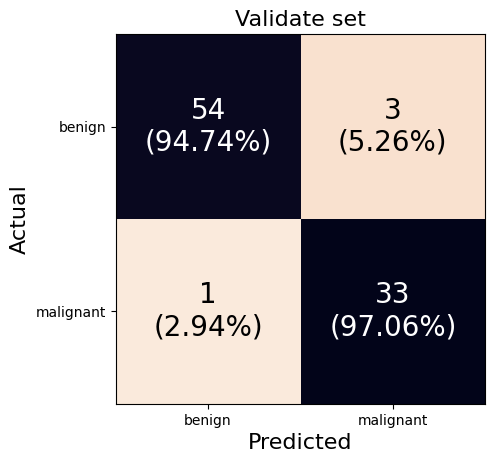

################# test set ##################
Best Threshold=0.454902
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


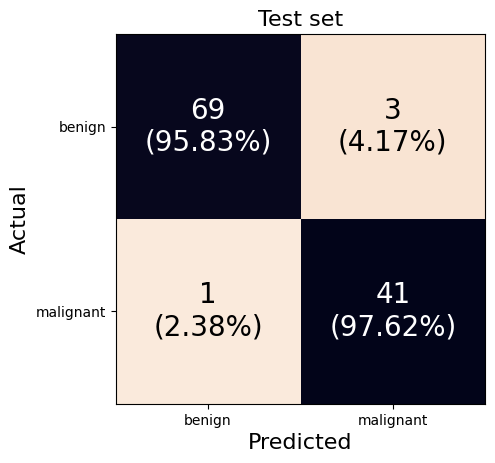

---------------------------------------
AUC validate: 99.33%
AUC test: 99.40%


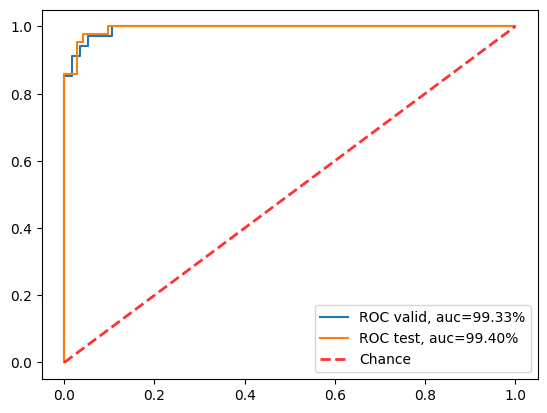

                   Variable      Coef
7                   area_se  1.471413
1                 area_mean  0.783946
3            concavity_mean  0.458683
11     fractal_dimension_se  0.361798
14           symmetry_worst  0.349946
15  fractal_dimension_worst  0.330638
0              texture_mean  0.279543
10              symmetry_se  0.161870
8             smoothness_se  0.118686
13          concavity_worst  0.094315
9              concavity_se  0.077093
2           smoothness_mean  0.008929
4             symmetry_mean  0.000000
5    fractal_dimension_mean  0.000000
6                texture_se  0.000000
12         smoothness_worst  0.000000
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
8    906564         B         13.98      656.1          0.10310   
26   866458         B         16.39      674.5          0.11500   
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47

In [31]:
# hello world!
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## split2

In [113]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [114]:
train_param1(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param1/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.906055
FPR: 0.0000
TPR: 0.9118
Confusion Matrix
----------------
[[57  0]
 [ 3 31]] 

----------------
split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


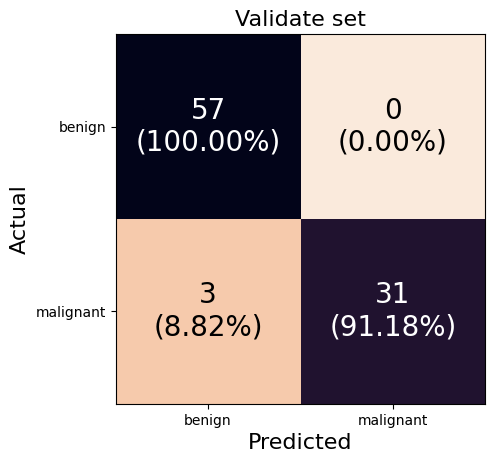

################# test set ##################
Best Threshold=0.491112
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


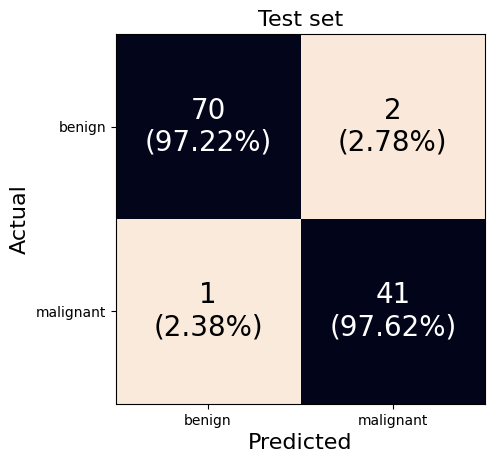

---------------------------------------
AUC validate: 99.07%
AUC test: 99.60%


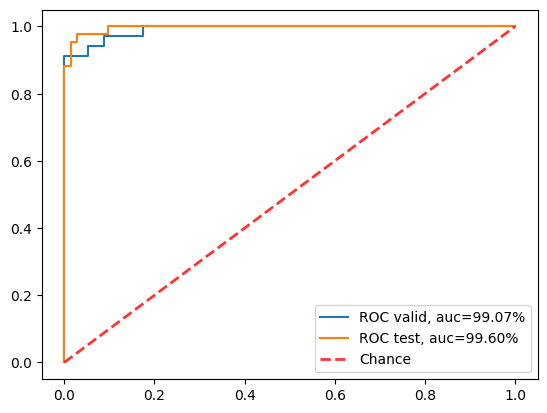

                   Variable      Coef
7                   area_se  1.140373
1                 area_mean  0.965126
11     fractal_dimension_se  0.595803
3            concavity_mean  0.531566
0              texture_mean  0.418177
12         smoothness_worst  0.343866
14           symmetry_worst  0.284672
15  fractal_dimension_worst  0.253546
13          concavity_worst  0.147540
6                texture_se  0.044415
4             symmetry_mean  0.036300
2           smoothness_mean  0.000000
5    fractal_dimension_mean  0.000000
8             smoothness_se  0.000000
9              concavity_se  0.000000
10              symmetry_se  0.000000
################# false predict ##################
           id diagnosis  texture_mean  area_mean  smoothness_mean  \
57     855167         M         21.58      563.0          0.08162   
79  881094802         M         25.56      948.0          0.10060   
87   91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmet

In [115]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## split3

In [35]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [36]:
train_param1(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param1/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.493356
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


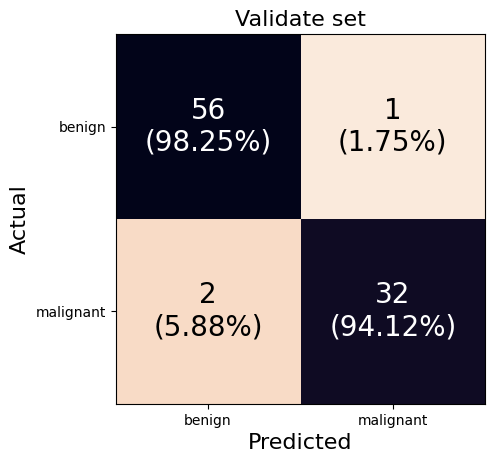

################# test set ##################
Best Threshold=0.473056
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


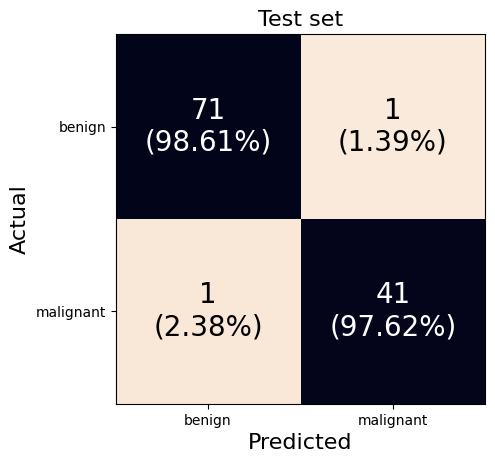

---------------------------------------
AUC validate: 97.94%
AUC test: 99.80%


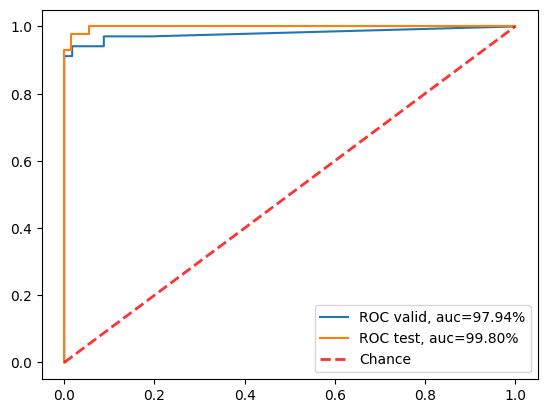

                   Variable      Coef
1                 area_mean  1.133638
7                   area_se  1.118773
12         smoothness_worst  0.451059
3            concavity_mean  0.382829
0              texture_mean  0.365637
14           symmetry_worst  0.332549
10              symmetry_se  0.260183
11     fractal_dimension_se  0.182329
5    fractal_dimension_mean  0.149053
13          concavity_worst  0.140085
15  fractal_dimension_worst  0.115176
9              concavity_se  0.037103
4             symmetry_mean  0.036410
2           smoothness_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
81    869691         M         16.58      432.0          0.10910   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_m

In [37]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## split4

In [38]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [39]:
train_param1(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param1/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.595515
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


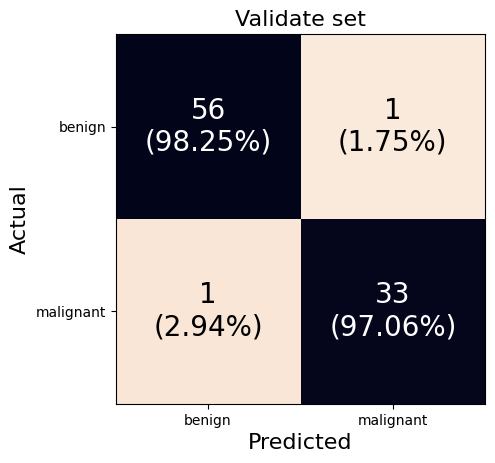

################# test set ##################
Best Threshold=0.521308
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


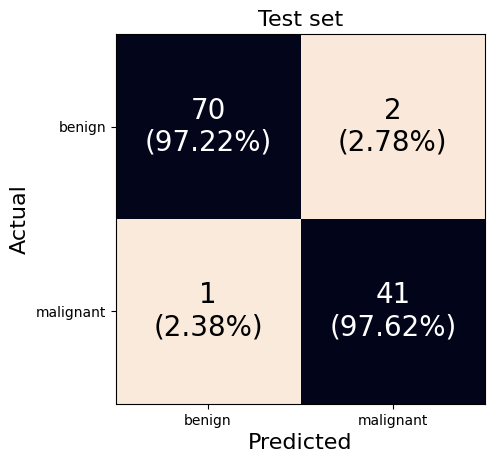

---------------------------------------
AUC validate: 99.59%
AUC test: 99.64%


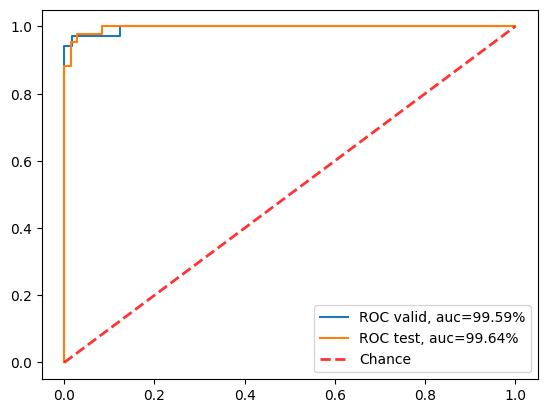

                   Variable      Coef
7                   area_se  1.350536
1                 area_mean  0.856747
14           symmetry_worst  0.413665
3            concavity_mean  0.384003
0              texture_mean  0.350756
12         smoothness_worst  0.297579
13          concavity_worst  0.228302
9              concavity_se  0.204981
10              symmetry_se  0.170115
4             symmetry_mean  0.073265
11     fractal_dimension_se  0.068533
5    fractal_dimension_mean  0.029072
8             smoothness_se  0.023532
6                texture_se  0.014373
2           smoothness_mean  0.000000
15  fractal_dimension_worst  0.000000
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.18

In [40]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## split5

In [41]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [42]:
train_param1(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param1/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.707769
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


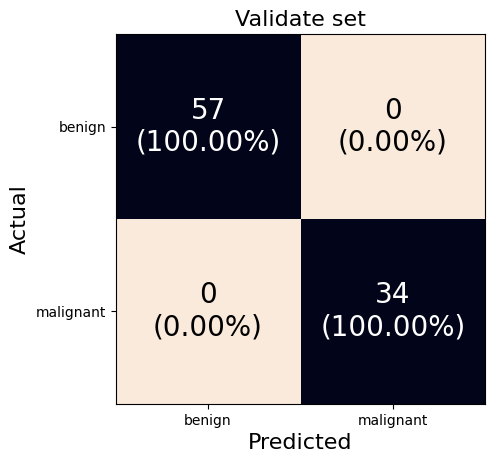

################# test set ##################
Best Threshold=0.607321
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


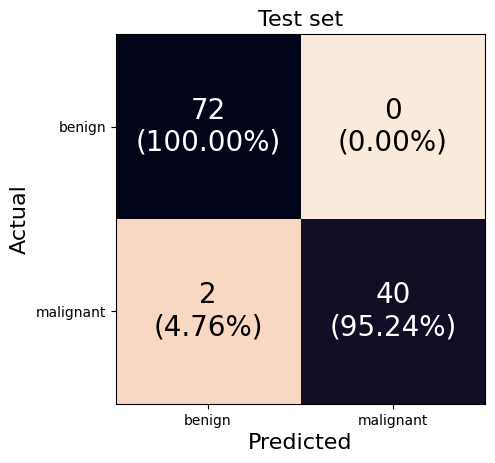

---------------------------------------
AUC validate: 100.00%
AUC test: 99.77%


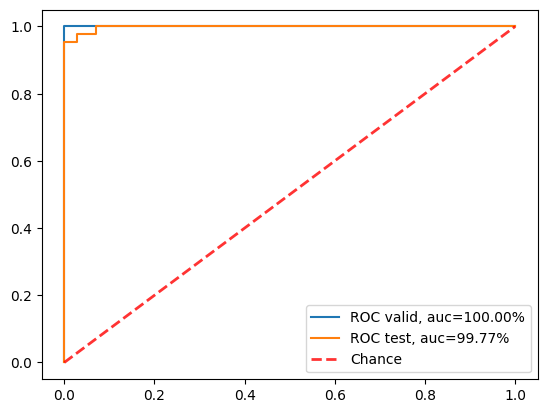

                   Variable      Coef
7                   area_se  1.144972
1                 area_mean  0.731296
3            concavity_mean  0.600537
0              texture_mean  0.299259
14           symmetry_worst  0.297831
11     fractal_dimension_se  0.263011
12         smoothness_worst  0.243781
13          concavity_worst  0.223658
9              concavity_se  0.210888
10              symmetry_se  0.127428
8             smoothness_se  0.080370
4             symmetry_mean  0.071018
15  fractal_dimension_worst  0.060160
5    fractal_dimension_mean  0.049062
6                texture_se  0.021252
2           smoothness_mean  0.000000
################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Inde

In [43]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

# Parameter2

## split1

In [44]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [45]:
train_param2(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param2/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.513143
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


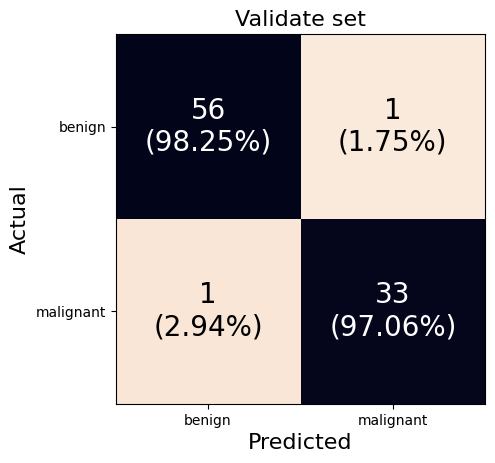

################# test set ##################
Best Threshold=0.539460
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


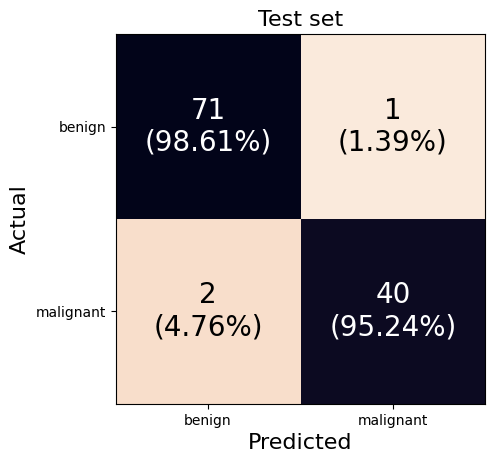

---------------------------------------
AUC validate: 99.59%
AUC test: 99.60%


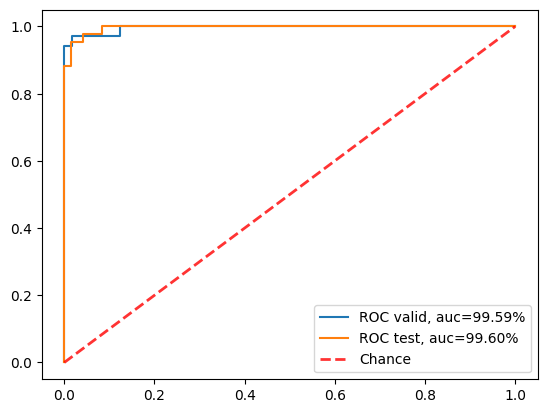

                   Variable      Coef
7                   area_se  1.679081
1                 area_mean  1.637892
3            concavity_mean  1.020506
0              texture_mean  0.849179
13          concavity_worst  0.654835
14           symmetry_worst  0.522553
9              concavity_se  0.514356
15  fractal_dimension_worst  0.499325
2           smoothness_mean  0.474164
5    fractal_dimension_mean  0.458880
10              symmetry_se  0.450772
11     fractal_dimension_se  0.359909
12         smoothness_worst  0.144685
6                texture_se  0.086997
8             smoothness_se  0.045892
4             symmetry_mean  0.013683
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47      506.3          0.09055   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0

In [46]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## split2

In [47]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [48]:
train_param2(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param2/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.754926
FPR: 0.0000
TPR: 0.9118
Confusion Matrix
----------------
[[57  0]
 [ 3 31]] 

----------------
split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


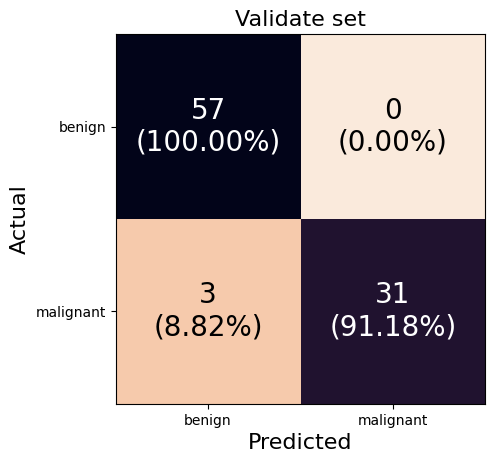

################# test set ##################
Best Threshold=0.536234
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


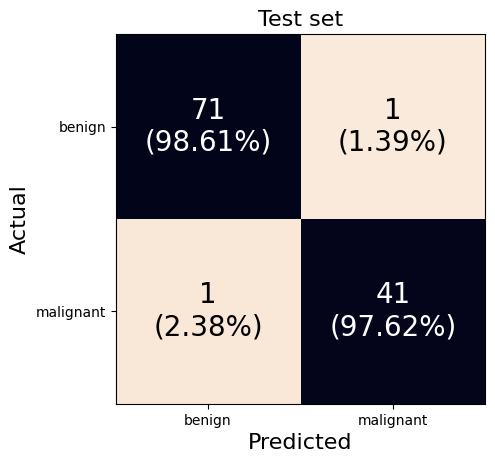

---------------------------------------
AUC validate: 99.02%
AUC test: 99.60%


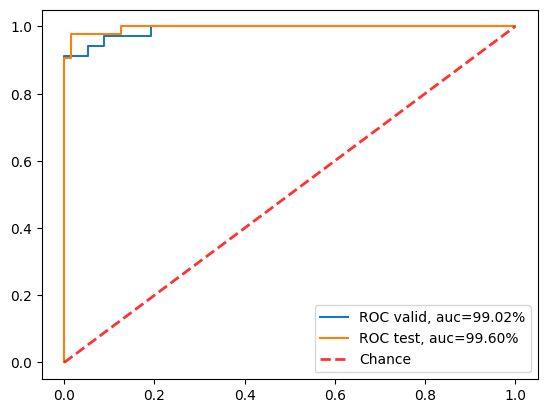

                   Variable      Coef
1                 area_mean  1.687130
7                   area_se  1.367674
3            concavity_mean  1.057054
0              texture_mean  0.960147
14           symmetry_worst  0.781290
13          concavity_worst  0.746730
11     fractal_dimension_se  0.701179
12         smoothness_worst  0.698308
5    fractal_dimension_mean  0.601586
2           smoothness_mean  0.515483
15  fractal_dimension_worst  0.356643
9              concavity_se  0.265651
10              symmetry_se  0.129854
4             symmetry_mean  0.115883
6                texture_se  0.063372
8             smoothness_se  0.019571
################# false predict ##################
           id diagnosis  texture_mean  area_mean  smoothness_mean  \
57     855167         M         21.58      563.0          0.08162   
79  881094802         M         25.56      948.0          0.10060   
87   91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmet

In [49]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## split3

In [50]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [51]:
train_param2(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param2/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.344677
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


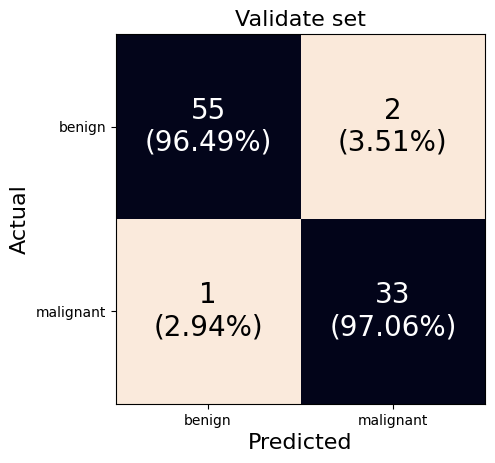

################# test set ##################
Best Threshold=0.406897
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


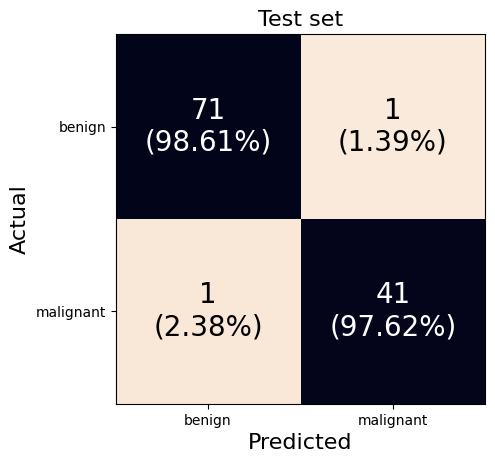

---------------------------------------
AUC validate: 98.45%
AUC test: 99.54%


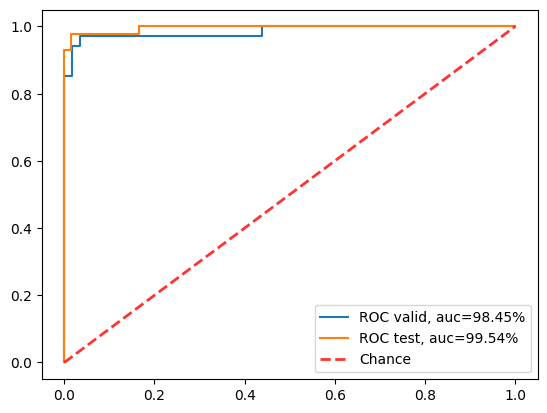

                   Variable      Coef
1                 area_mean  1.922847
7                   area_se  1.559049
3            concavity_mean  1.104931
0              texture_mean  0.891292
5    fractal_dimension_mean  0.741005
13          concavity_worst  0.626440
2           smoothness_mean  0.613671
14           symmetry_worst  0.581571
12         smoothness_worst  0.544427
8             smoothness_se  0.453775
10              symmetry_se  0.416414
9              concavity_se  0.272851
15  fractal_dimension_worst  0.227835
6                texture_se  0.168136
11     fractal_dimension_se  0.121334
4             symmetry_mean  0.034862
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
28    911366         B         18.18      408.8          0.11750   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_m

In [52]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## split4

In [53]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [54]:
train_param2(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param2/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.630537
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


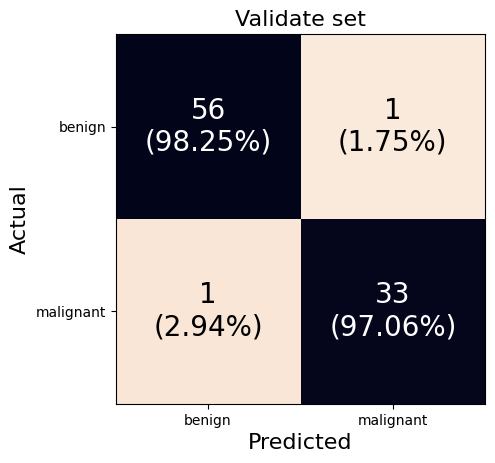

################# test set ##################
Best Threshold=0.420280
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


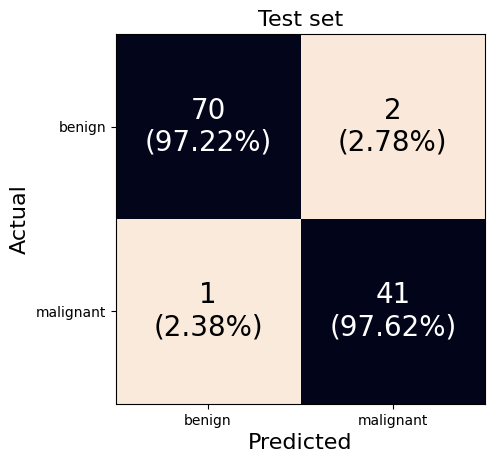

---------------------------------------
AUC validate: 99.33%
AUC test: 99.44%


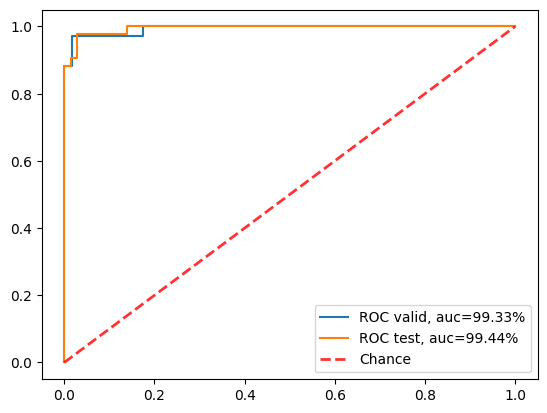

                   Variable      Coef
1                 area_mean  1.681775
7                   area_se  1.477904
3            concavity_mean  1.100662
0              texture_mean  0.924238
13          concavity_worst  0.821201
14           symmetry_worst  0.783619
5    fractal_dimension_mean  0.634735
2           smoothness_mean  0.427575
15  fractal_dimension_worst  0.375051
9              concavity_se  0.332830
12         smoothness_worst  0.326216
6                texture_se  0.188843
11     fractal_dimension_se  0.175661
10              symmetry_se  0.145240
4             symmetry_mean  0.066323
8             smoothness_se  0.066081
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.18

In [55]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## split5

In [56]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [57]:
train_param2(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param2/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.696512
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


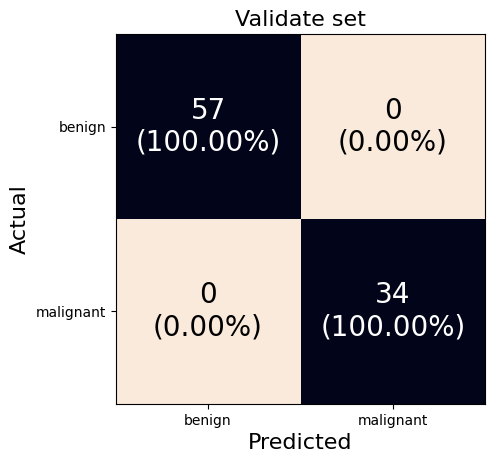

################# test set ##################
Best Threshold=0.526776
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


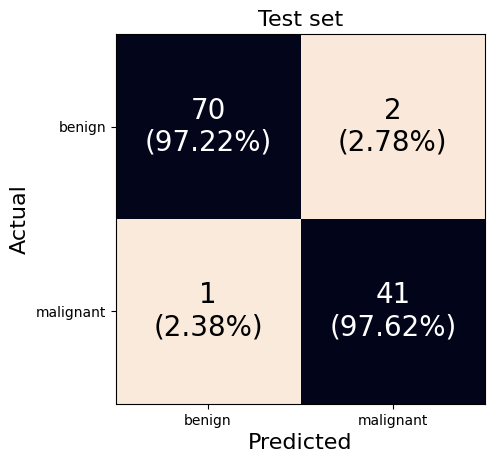

---------------------------------------
AUC validate: 100.00%
AUC test: 99.77%


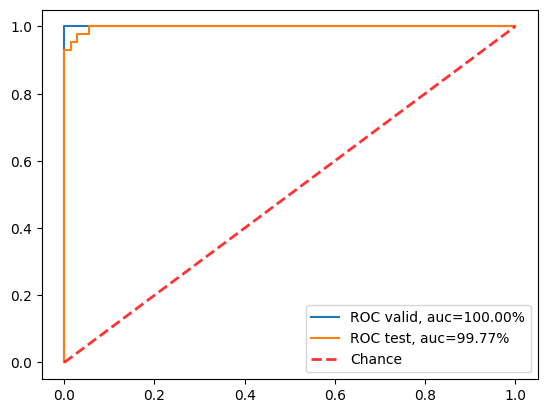

                   Variable      Coef
1                 area_mean  1.703428
7                   area_se  1.378996
3            concavity_mean  1.159103
13          concavity_worst  0.712035
0              texture_mean  0.688046
5    fractal_dimension_mean  0.630151
9              concavity_se  0.599395
14           symmetry_worst  0.545302
12         smoothness_worst  0.417382
11     fractal_dimension_se  0.399589
2           smoothness_mean  0.393300
15  fractal_dimension_worst  0.349738
10              symmetry_se  0.296110
6                texture_se  0.122250
8             smoothness_se  0.085379
4             symmetry_mean  0.007769
################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Inde

In [58]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

# Parameter 3

## split1

In [59]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [60]:
train_param3(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param3/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.189037
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


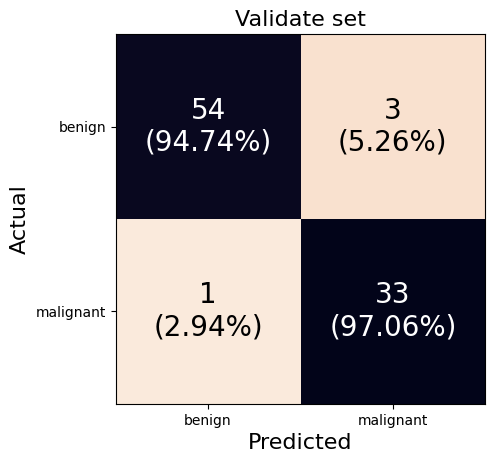

################# test set ##################
Best Threshold=0.484740
FPR: 0.0556
TPR: 1.0000
Confusion Matrix
----------------
[[68  4]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 94.44%
Accuracy: 96.49%
Precision: 91.30%
Sensitivity: 100.00%
Precision: 91.30%
F1: 95.45%


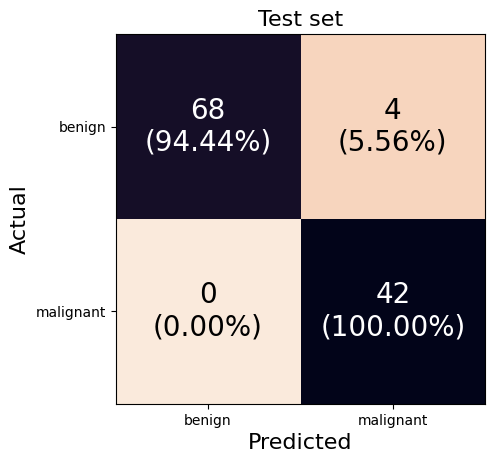

---------------------------------------
AUC validate: 99.02%
AUC test: 99.40%


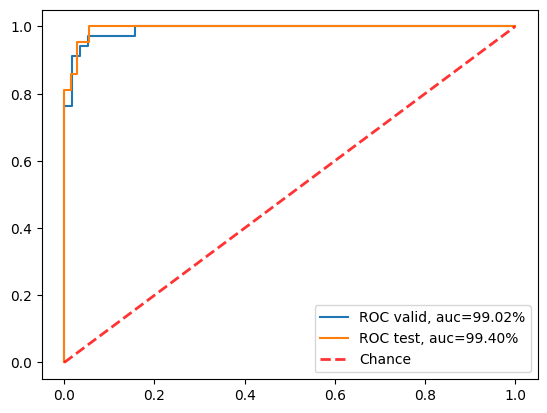

                   Variable      Coef
7                   area_se  5.781938
1                 area_mean  3.080046
11     fractal_dimension_se  2.518372
3            concavity_mean  2.224693
15  fractal_dimension_worst  1.960368
14           symmetry_worst  1.812754
10              symmetry_se  1.456480
12         smoothness_worst  1.422961
0              texture_mean  1.157053
8             smoothness_se  1.037572
2           smoothness_mean  0.850570
13          concavity_worst  0.807438
9              concavity_se  0.713996
4             symmetry_mean  0.163424
6                texture_se  0.085389
5    fractal_dimension_mean  0.038794
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
8    906564         B         13.98      656.1          0.10310   
26   866458         B         16.39      674.5          0.11500   
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47

In [61]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## split2

In [62]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [63]:
train_param3(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param3/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.969195
FPR: 0.0000
TPR: 0.9118
Confusion Matrix
----------------
[[57  0]
 [ 3 31]] 

----------------
split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


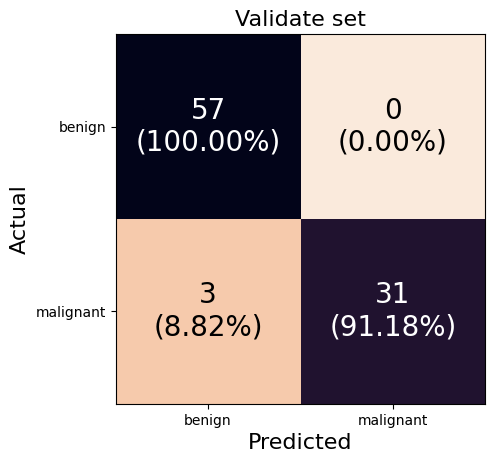

################# test set ##################
Best Threshold=0.536470
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


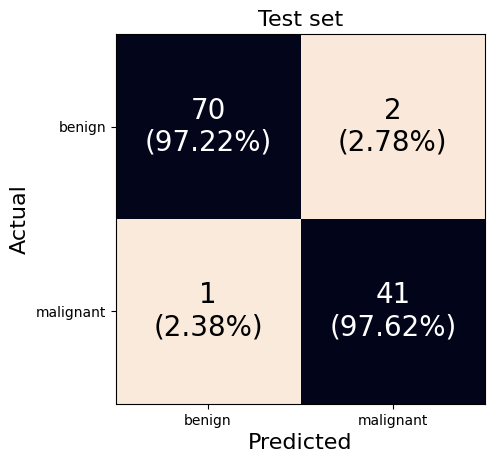

---------------------------------------
AUC validate: 98.86%
AUC test: 99.60%


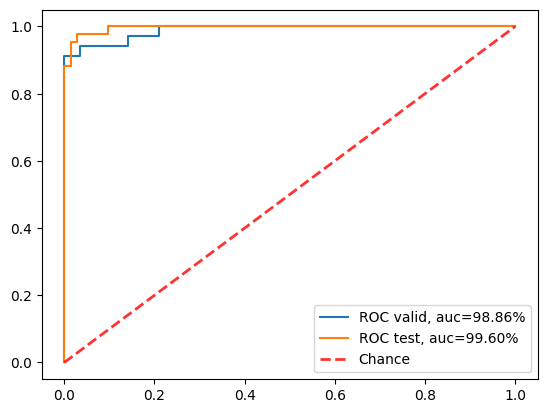

                   Variable      Coef
7                   area_se  4.574683
1                 area_mean  4.009568
3            concavity_mean  2.828091
11     fractal_dimension_se  2.811688
15  fractal_dimension_worst  1.783918
0              texture_mean  1.505408
14           symmetry_worst  1.429719
12         smoothness_worst  0.997643
13          concavity_worst  0.957030
9              concavity_se  0.845681
5    fractal_dimension_mean  0.719475
2           smoothness_mean  0.652342
6                texture_se  0.537569
4             symmetry_mean  0.523042
8             smoothness_se  0.334738
10              symmetry_se  0.038403
################# false predict ##################
           id diagnosis  texture_mean  area_mean  smoothness_mean  \
57     855167         M         21.58      563.0          0.08162   
79  881094802         M         25.56      948.0          0.10060   
87   91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmet

In [64]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## split3

In [65]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [66]:
train_param3(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param3/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.752801
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


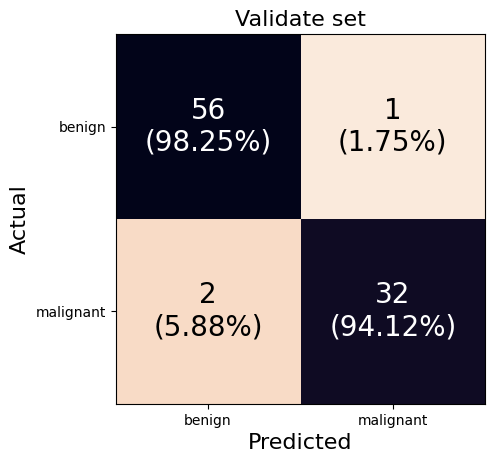

################# test set ##################
Best Threshold=0.346343
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


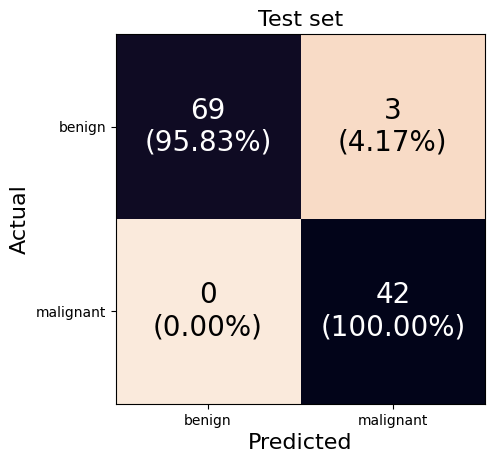

---------------------------------------
AUC validate: 97.42%
AUC test: 99.74%


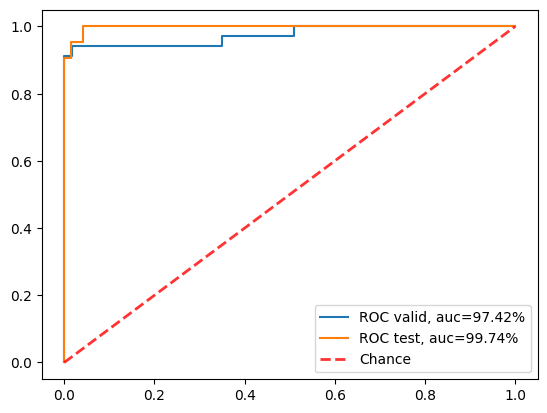

                   Variable      Coef
1                 area_mean  4.624924
7                   area_se  4.403444
3            concavity_mean  2.314956
0              texture_mean  1.841798
10              symmetry_se  1.756154
5    fractal_dimension_mean  1.647624
14           symmetry_worst  1.566781
11     fractal_dimension_se  1.363436
15  fractal_dimension_worst  1.183423
12         smoothness_worst  1.117646
2           smoothness_mean  0.922097
8             smoothness_se  0.818791
13          concavity_worst  0.816024
4             symmetry_mean  0.584013
9              concavity_se  0.395615
6                texture_se  0.047991
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
81    869691         M         16.58      432.0          0.10910   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_m

In [67]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## split4

In [68]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [69]:
train_param3(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param3/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.637330
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


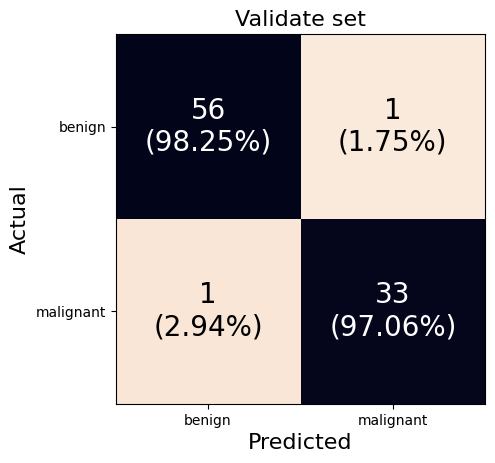

################# test set ##################
Best Threshold=0.675861
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


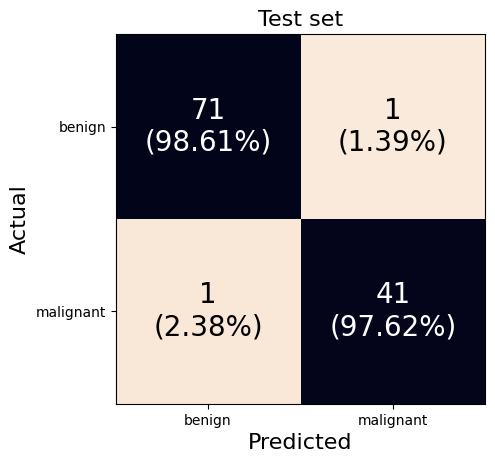

---------------------------------------
AUC validate: 99.69%
AUC test: 99.77%


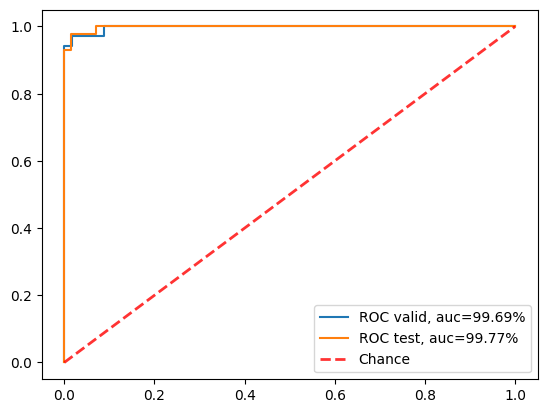

                   Variable      Coef
7                   area_se  4.466227
1                 area_mean  3.235606
14           symmetry_worst  2.116295
3            concavity_mean  1.954333
9              concavity_se  1.291375
13          concavity_worst  1.203823
0              texture_mean  1.199588
5    fractal_dimension_mean  1.133846
2           smoothness_mean  1.009370
10              symmetry_se  0.968281
11     fractal_dimension_se  0.943024
15  fractal_dimension_worst  0.874042
8             smoothness_se  0.580488
4             symmetry_mean  0.449250
6                texture_se  0.330170
12         smoothness_worst  0.253666
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.18

In [70]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## split5

In [71]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [72]:
train_param3(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param3/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.914606
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


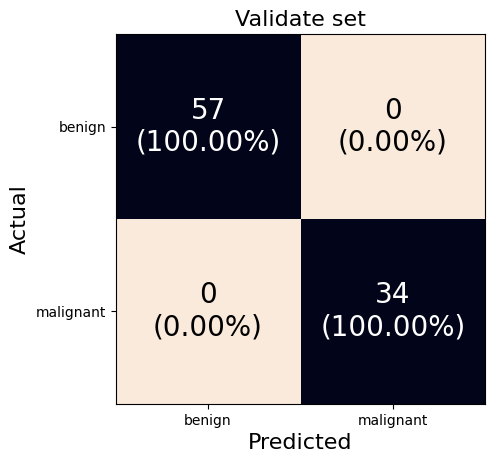

################# test set ##################
Best Threshold=0.781429
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


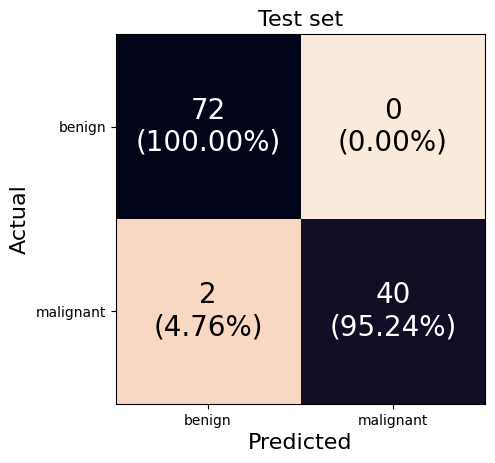

---------------------------------------
AUC validate: 100.00%
AUC test: 99.80%


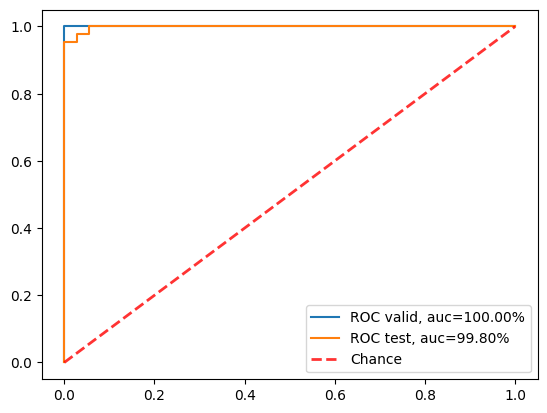

                   Variable      Coef
7                   area_se  4.417430
1                 area_mean  2.772625
3            concavity_mean  2.638365
11     fractal_dimension_se  1.792493
14           symmetry_worst  1.716288
13          concavity_worst  1.186669
15  fractal_dimension_worst  1.147158
9              concavity_se  1.121988
0              texture_mean  1.100454
5    fractal_dimension_mean  0.997244
10              symmetry_se  0.892281
2           smoothness_mean  0.800585
8             smoothness_se  0.740092
4             symmetry_mean  0.706718
6                texture_se  0.201378
12         smoothness_worst  0.093824
################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Inde

In [73]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

# Parameter 4

## split1

In [74]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [75]:
train_param4(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param4/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.463268
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


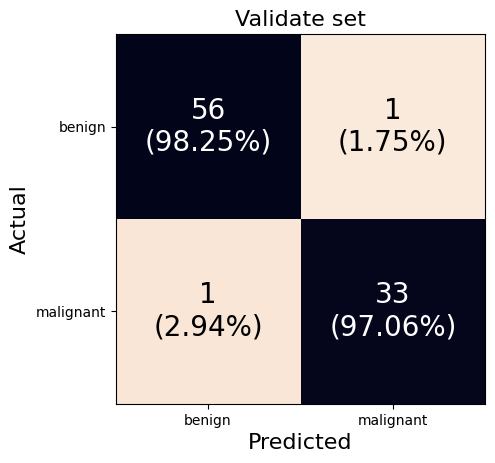

################# test set ##################
Best Threshold=0.490857
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


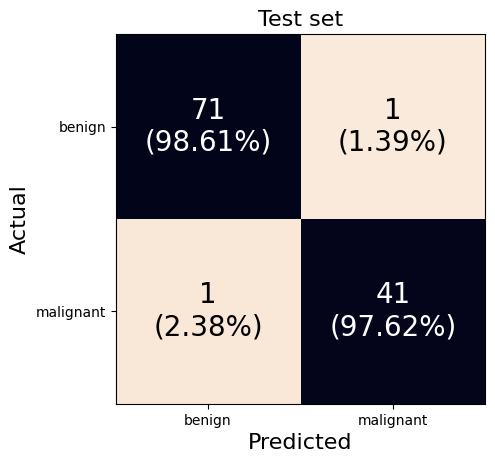

---------------------------------------
AUC validate: 99.54%
AUC test: 99.74%


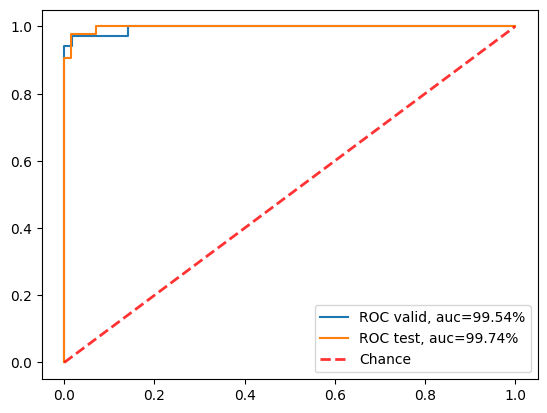

                   Variable      Coef
7                   area_se  1.708932
1                 area_mean  1.676666
3            concavity_mean  1.053888
0              texture_mean  0.758009
13          concavity_worst  0.634330
14           symmetry_worst  0.610719
5    fractal_dimension_mean  0.505942
15  fractal_dimension_worst  0.415760
2           smoothness_mean  0.408180
9              concavity_se  0.382252
11     fractal_dimension_se  0.380184
10              symmetry_se  0.329144
12         smoothness_worst  0.153421
4             symmetry_mean  0.131054
8             smoothness_se  0.060710
6                texture_se  0.031641
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47      506.3          0.09055   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0

In [76]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## split2

In [77]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [78]:
train_param4(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param4/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.330000
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


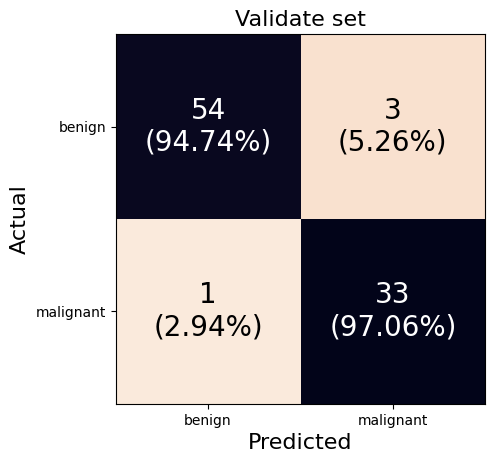

################# test set ##################
Best Threshold=0.581103
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


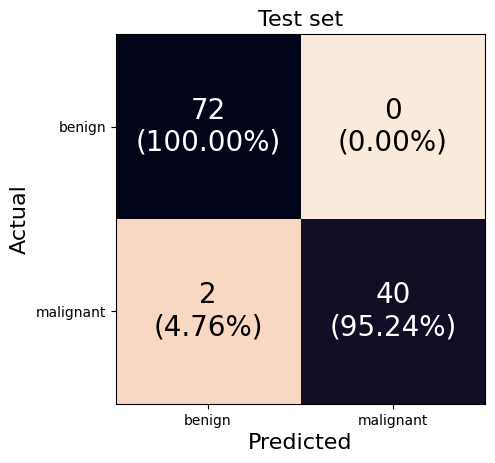

---------------------------------------
AUC validate: 99.12%
AUC test: 99.67%


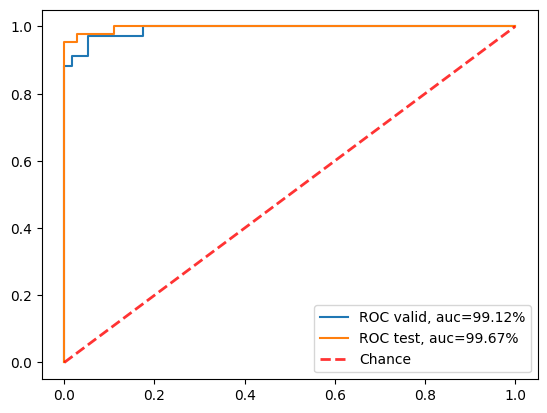

                   Variable      Coef
1                 area_mean  1.695751
7                   area_se  1.460730
3            concavity_mean  1.141741
0              texture_mean  0.920095
13          concavity_worst  0.785707
14           symmetry_worst  0.681480
12         smoothness_worst  0.618801
11     fractal_dimension_se  0.556262
5    fractal_dimension_mean  0.544762
2           smoothness_mean  0.401564
15  fractal_dimension_worst  0.377409
9              concavity_se  0.181722
6                texture_se  0.147500
10              symmetry_se  0.139390
8             smoothness_se  0.091776
4             symmetry_mean  0.022496
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
11   859471         B         17.33      250.5          0.10660   
12  9112366         B         29.29      415.1          0.09357   
55   883270         B         27.85      623.9          0.08223   
57   855167         M         21.58

In [79]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## split3

In [80]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [81]:
train_param4(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param4/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.435132
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


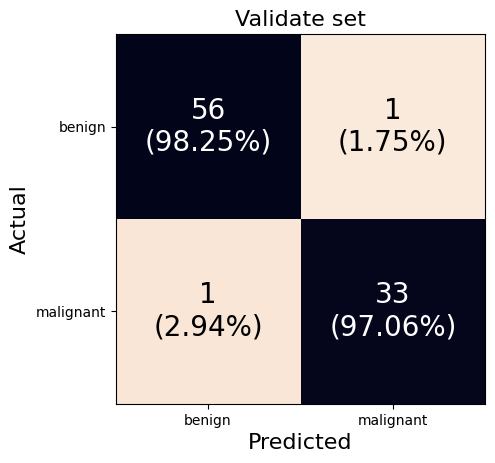

################# test set ##################
Best Threshold=0.488542
FPR: 0.0000
TPR: 0.9762
Confusion Matrix
----------------
[[72  0]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 100.00%
Accuracy: 99.12%
Precision: 100.00%
Sensitivity: 97.62%
Precision: 100.00%
F1: 98.80%


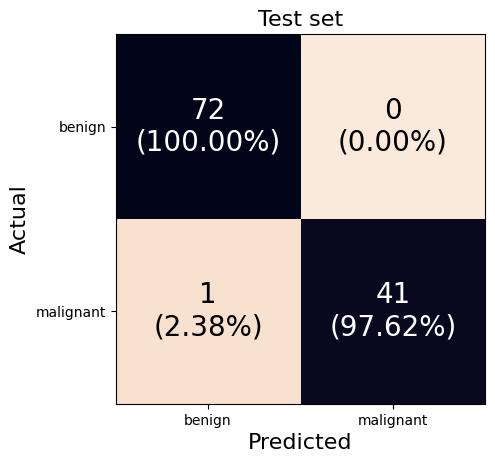

---------------------------------------
AUC validate: 98.19%
AUC test: 99.83%


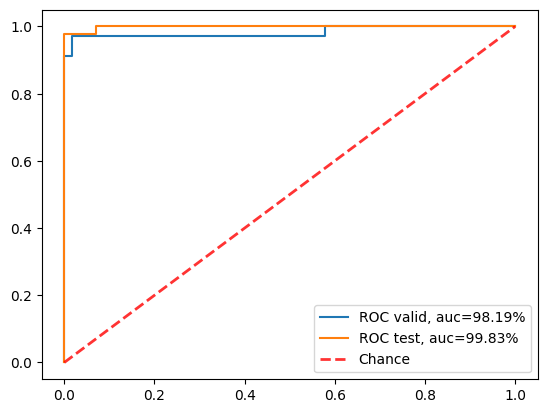

                   Variable      Coef
1                 area_mean  1.799826
7                   area_se  1.492705
3            concavity_mean  1.019476
0              texture_mean  0.904330
5    fractal_dimension_mean  0.734987
14           symmetry_worst  0.696011
13          concavity_worst  0.674914
12         smoothness_worst  0.536265
10              symmetry_se  0.471053
2           smoothness_mean  0.392946
9              concavity_se  0.339022
15  fractal_dimension_worst  0.334302
11     fractal_dimension_se  0.259678
4             symmetry_mean  0.020937
6                texture_se  0.020853
8             smoothness_se  0.017674
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
1          0.04201       

In [82]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## split4

In [83]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [84]:
train_param4(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param4/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.646106
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


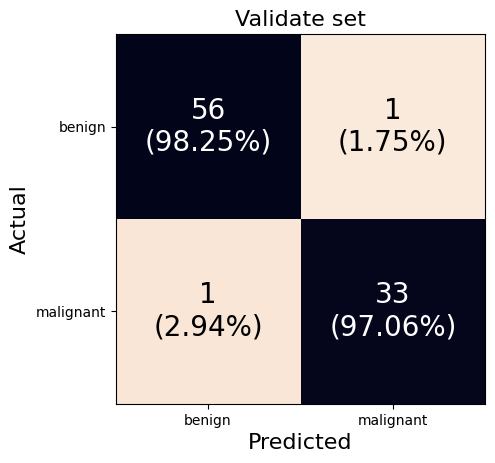

################# test set ##################
Best Threshold=0.502820
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


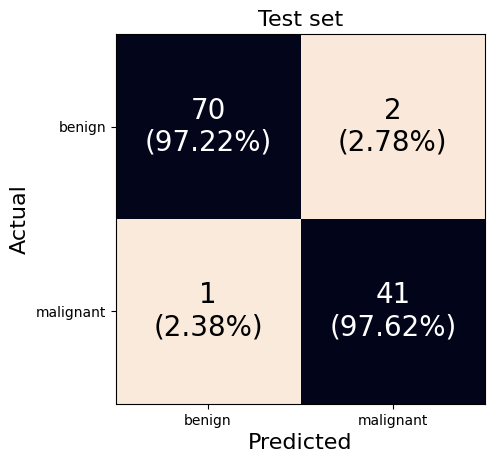

---------------------------------------
AUC validate: 99.54%
AUC test: 99.64%


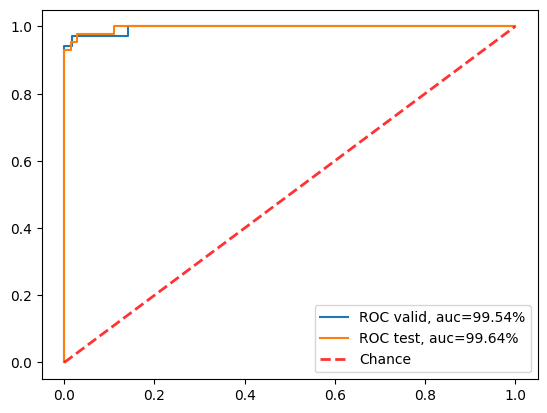

                   Variable      Coef
1                 area_mean  1.738492
7                   area_se  1.472068
3            concavity_mean  0.990978
0              texture_mean  0.921554
13          concavity_worst  0.752631
5    fractal_dimension_mean  0.685541
14           symmetry_worst  0.679561
2           smoothness_mean  0.447177
9              concavity_se  0.441870
15  fractal_dimension_worst  0.371144
12         smoothness_worst  0.354073
10              symmetry_se  0.323352
11     fractal_dimension_se  0.301968
8             smoothness_se  0.133142
6                texture_se  0.099894
4             symmetry_mean  0.002202
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.18

In [85]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## split5

In [86]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [87]:
train_param4(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param4/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.569424
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


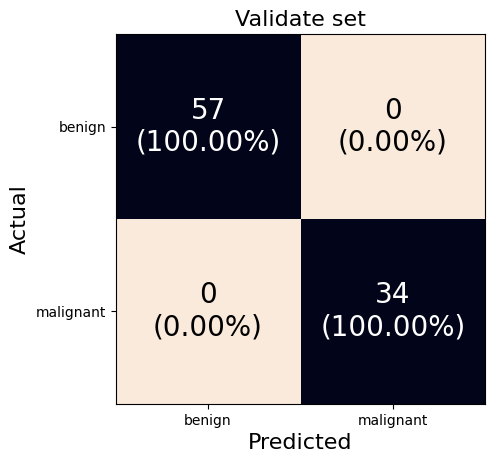

################# test set ##################
Best Threshold=0.504535
FPR: 0.0000
TPR: 0.9762
Confusion Matrix
----------------
[[72  0]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 100.00%
Accuracy: 99.12%
Precision: 100.00%
Sensitivity: 97.62%
Precision: 100.00%
F1: 98.80%


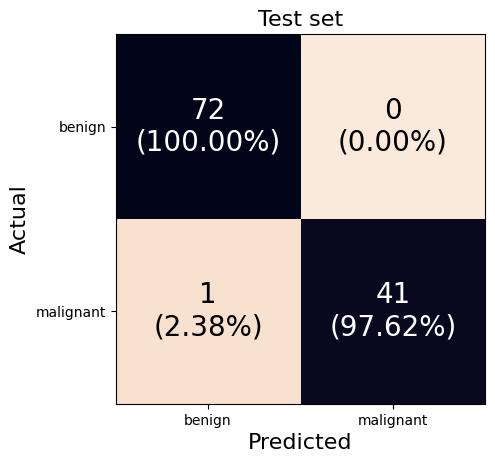

---------------------------------------
AUC validate: 100.00%
AUC test: 99.77%


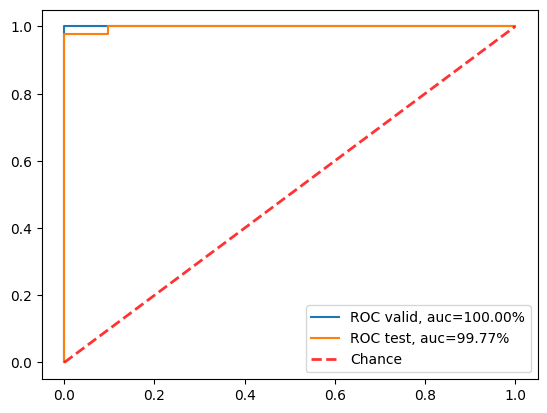

                   Variable      Coef
1                 area_mean  1.644502
7                   area_se  1.373613
3            concavity_mean  1.201300
13          concavity_worst  0.779455
0              texture_mean  0.740993
14           symmetry_worst  0.601681
5    fractal_dimension_mean  0.559206
12         smoothness_worst  0.495482
2           smoothness_mean  0.406565
9              concavity_se  0.397522
11     fractal_dimension_se  0.376403
15  fractal_dimension_worst  0.323793
10              symmetry_se  0.270761
6                texture_se  0.094498
8             smoothness_se  0.090853
4             symmetry_mean  0.016971
################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Inde

In [88]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

# Parameter 5

## split1

In [89]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [90]:
train_param5(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param5/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.566898
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


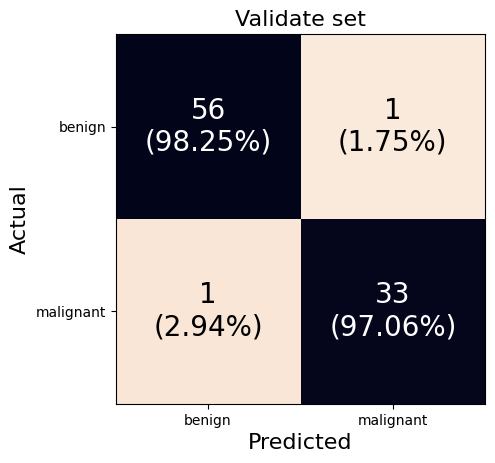

################# test set ##################
Best Threshold=0.592764
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


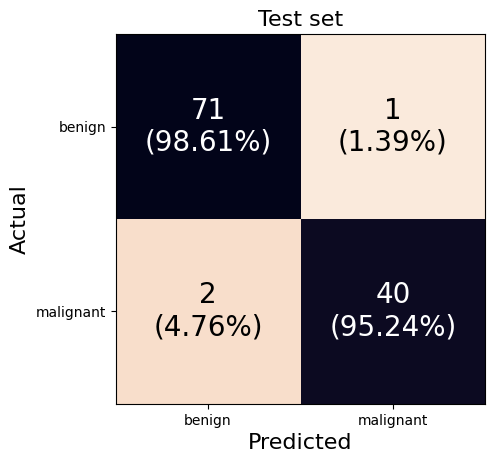

---------------------------------------
AUC validate: 99.59%
AUC test: 99.64%


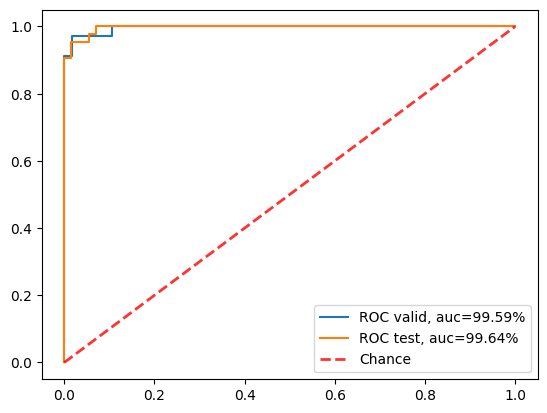

                   Variable      Coef
1                 area_mean  1.653658
7                   area_se  1.591140
3            concavity_mean  0.921780
0              texture_mean  0.888186
13          concavity_worst  0.621165
14           symmetry_worst  0.543128
5    fractal_dimension_mean  0.490729
9              concavity_se  0.406411
15  fractal_dimension_worst  0.394600
10              symmetry_se  0.391630
2           smoothness_mean  0.323169
11     fractal_dimension_se  0.285870
12         smoothness_worst  0.114142
8             smoothness_se  0.090069
4             symmetry_mean  0.000000
6                texture_se  0.000000
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  8711216         B         19.46      880.2          0.07445   
79   868202         M         22.47      506.3          0.09055   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.05150         0

In [91]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

## split2

In [92]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [93]:
train_param5(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param5/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.819855
FPR: 0.0000
TPR: 0.9118
Confusion Matrix
----------------
[[57  0]
 [ 3 31]] 

----------------
split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


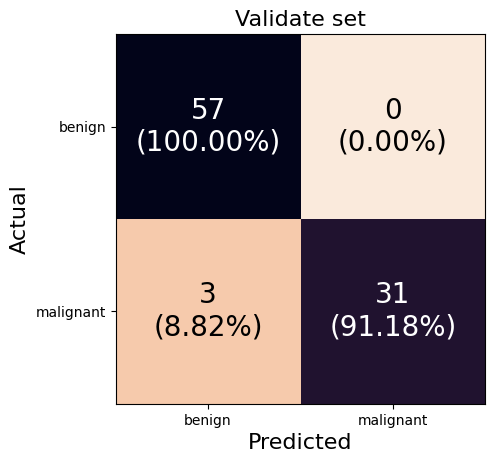

################# test set ##################
Best Threshold=0.524890
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


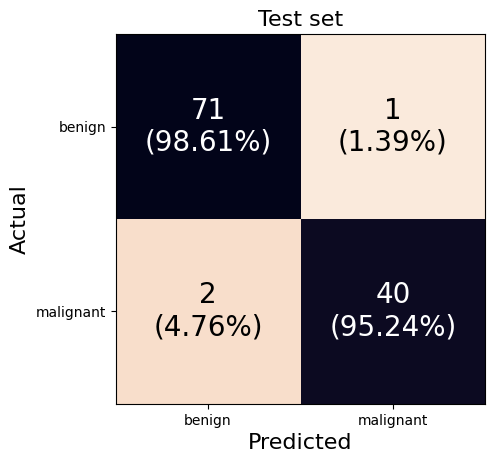

---------------------------------------
AUC validate: 99.28%
AUC test: 99.57%


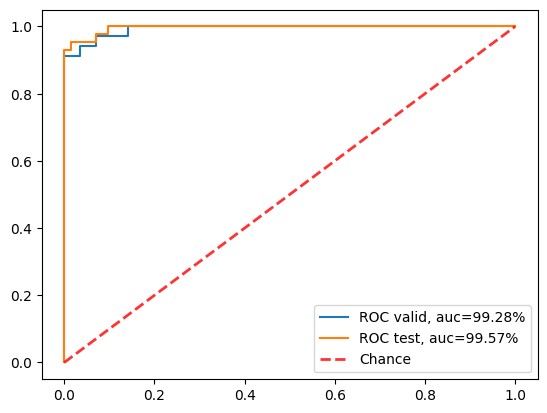

                   Variable      Coef
1                 area_mean  1.809043
7                   area_se  1.540004
3            concavity_mean  1.080648
0              texture_mean  1.007804
13          concavity_worst  0.681039
11     fractal_dimension_se  0.643720
14           symmetry_worst  0.572283
5    fractal_dimension_mean  0.562840
12         smoothness_worst  0.500993
2           smoothness_mean  0.374414
6                texture_se  0.250078
15  fractal_dimension_worst  0.208039
10              symmetry_se  0.180101
9              concavity_se  0.147614
4             symmetry_mean  0.000000
8             smoothness_se  0.000000
################# false predict ##################
           id diagnosis  texture_mean  area_mean  smoothness_mean  \
57     855167         M         21.58      563.0          0.08162   
79  881094802         M         25.56      948.0          0.10060   
87   91594602         M         19.07      701.9          0.09215   

    concavity_mean  symmet

In [94]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

## split3

In [95]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [96]:
train_param5(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param5/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.417015
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


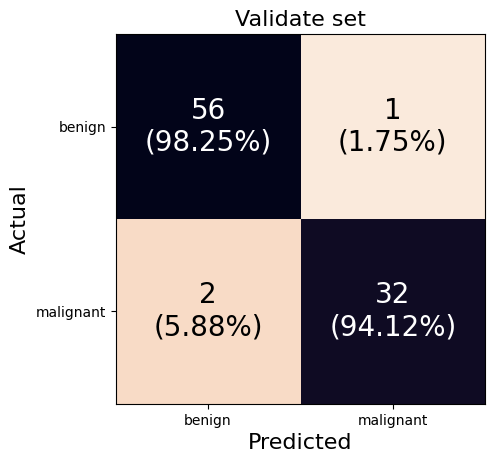

################# test set ##################
Best Threshold=0.444509
FPR: 0.0278
TPR: 1.0000
Confusion Matrix
----------------
[[70  2]
 [ 0 42]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 98.25%
Precision: 95.45%
Sensitivity: 100.00%
Precision: 95.45%
F1: 97.67%


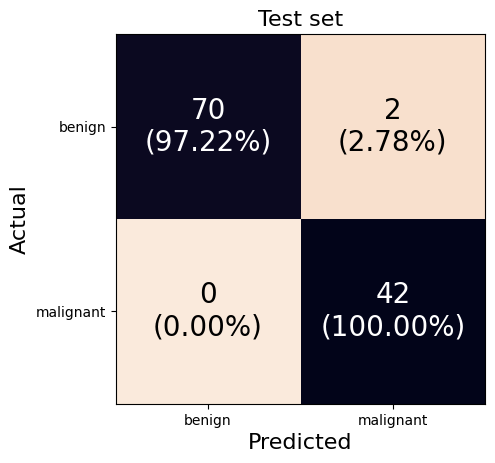

---------------------------------------
AUC validate: 97.88%
AUC test: 99.83%


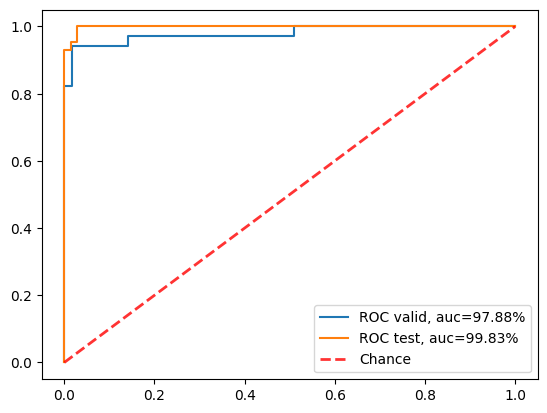

                   Variable      Coef
1                 area_mean  1.924885
7                   area_se  1.557011
3            concavity_mean  0.944230
0              texture_mean  0.850088
9              concavity_se  0.742146
5    fractal_dimension_mean  0.730255
12         smoothness_worst  0.629048
14           symmetry_worst  0.592725
10              symmetry_se  0.557319
13          concavity_worst  0.482716
2           smoothness_mean  0.362506
15  fractal_dimension_worst  0.335229
11     fractal_dimension_se  0.227727
4             symmetry_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
1   91813701         B         18.75      551.1          0.10750   
81    869691         M         16.58      432.0          0.10910   
87    892189         M         18.14      431.1          0.09968   

    concavity_mean  symmetry_m

In [97]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

## split4

In [98]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [99]:
train_param5(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param5/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.605711
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


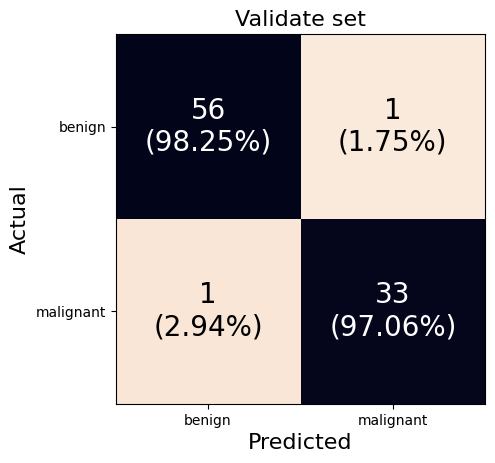

################# test set ##################
Best Threshold=0.500109
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


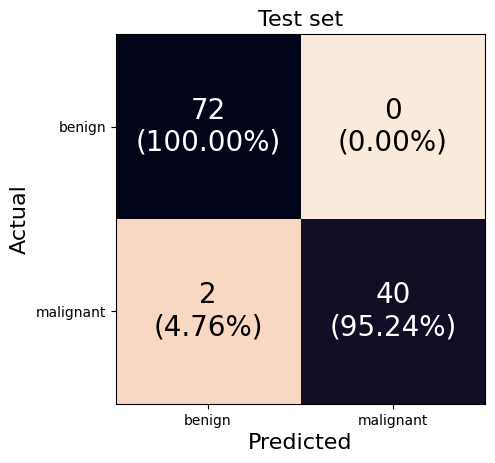

---------------------------------------
AUC validate: 99.48%
AUC test: 99.64%


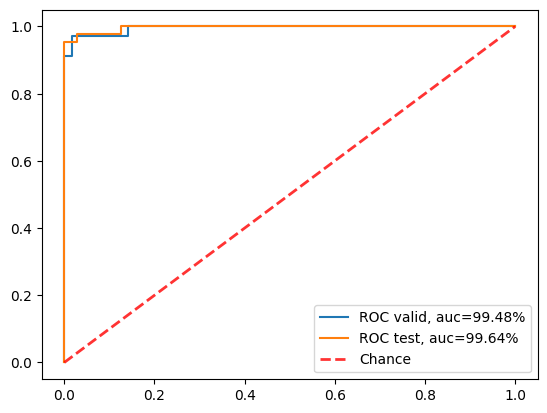

                   Variable      Coef
1                 area_mean  1.913547
7                   area_se  1.563183
3            concavity_mean  1.069814
14           symmetry_worst  0.842896
0              texture_mean  0.841635
13          concavity_worst  0.819308
5    fractal_dimension_mean  0.683431
12         smoothness_worst  0.504243
2           smoothness_mean  0.481959
15  fractal_dimension_worst  0.293162
9              concavity_se  0.282275
10              symmetry_se  0.230752
11     fractal_dimension_se  0.215268
8             smoothness_se  0.193524
4             symmetry_mean  0.000000
6                texture_se  0.000000
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
37  921386         B         24.99      656.4          0.08837   
70  859983         M         15.79      584.1          0.10070   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.10090         0.18

In [100]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

## split5

In [101]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [102]:
train_param5(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


../SGD/models/param5/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.513626
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


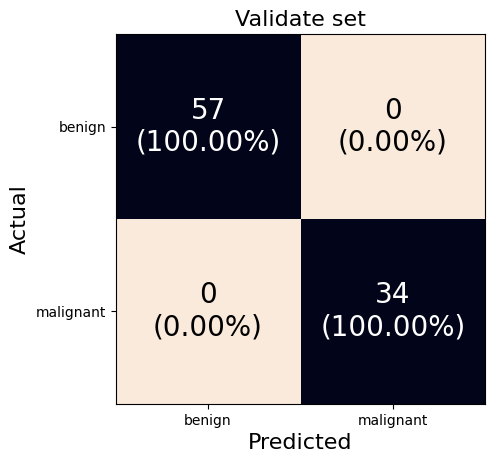

################# test set ##################
Best Threshold=0.454896
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


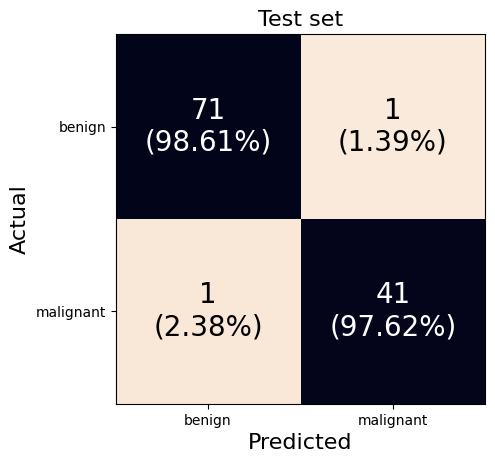

---------------------------------------
AUC validate: 100.00%
AUC test: 99.64%


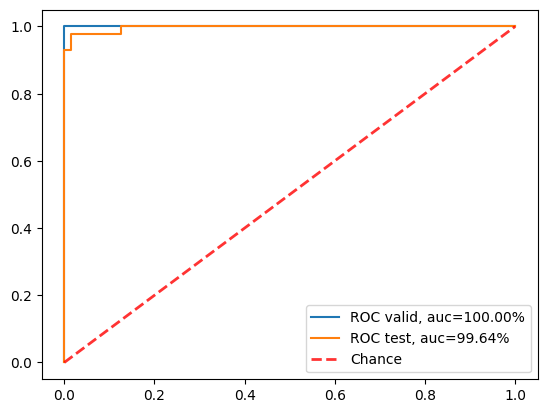

                   Variable      Coef
1                 area_mean  1.809511
7                   area_se  1.367517
3            concavity_mean  1.125944
0              texture_mean  0.754667
13          concavity_worst  0.733868
5    fractal_dimension_mean  0.653551
14           symmetry_worst  0.582150
12         smoothness_worst  0.549184
2           smoothness_mean  0.463595
11     fractal_dimension_se  0.409613
8             smoothness_se  0.386110
9              concavity_se  0.382180
10              symmetry_se  0.216404
15  fractal_dimension_worst  0.211816
4             symmetry_mean  0.000000
6                texture_se  0.000000
################# false predict ##################
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Inde

In [103]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# Overall

## param1

param1
split1
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%

split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 95.88 ± 3.35%
specificity: 98.25 ± 2.15%
accuracy: 97.36 ± 1.67%
precision: 97.14 ± 3.40%
f1_score: 96.45 ± 2.22%


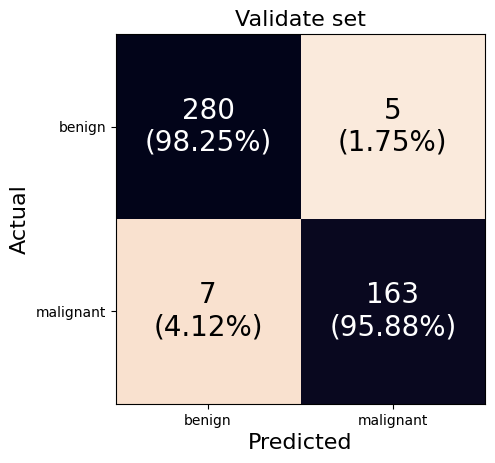

AUC1: 9918.47 ± 77.78%


In [104]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC1",param1_split1_AUC_val*100, param1_split2_AUC_val*100, param1_split3_AUC_val*100, param1_split4_AUC_val*100, param1_split5_AUC_val*100)

## param2

param2
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%

split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 96.47 ± 3.22%
specificity: 98.60 ± 1.47%
accuracy: 97.80 ± 1.35%
precision: 97.68 ± 2.40%
f1_score: 97.03 ± 1.83%


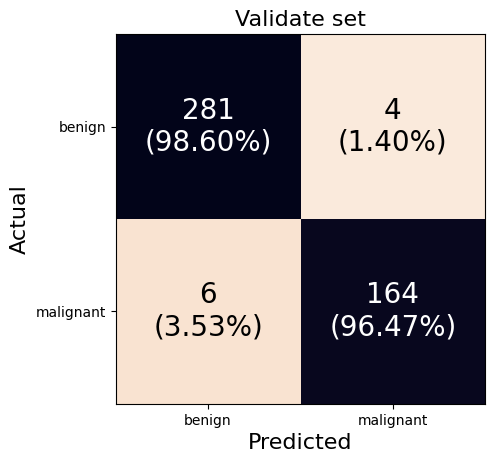

AUC1: 9927.76 ± 58.49%


In [105]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC1",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)

## param3

param3
split1
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%

split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 95.88 ± 3.35%
specificity: 98.25 ± 2.15%
accuracy: 97.36 ± 1.67%
precision: 97.14 ± 3.40%
f1_score: 96.45 ± 2.22%


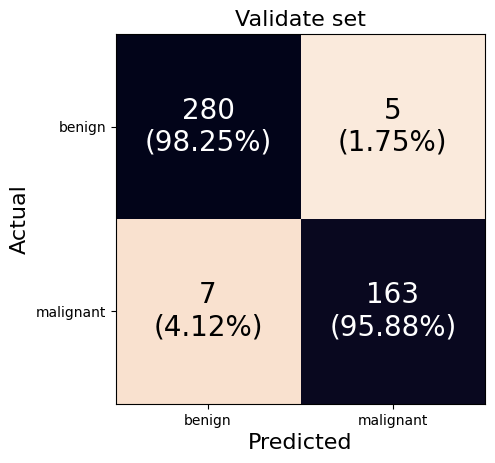

AUC1: 9899.90 ± 99.90%


In [106]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param3_split1_AUC_val*100, param3_split2_AUC_val*100, param3_split3_AUC_val*100, param3_split4_AUC_val*100, param3_split5_AUC_val*100)

## param4

param4
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 97.65 ± 1.32%
specificity: 97.89 ± 1.92%
accuracy: 97.80 ± 1.55%
precision: 96.57 ± 3.02%
f1_score: 97.09 ± 2.02%


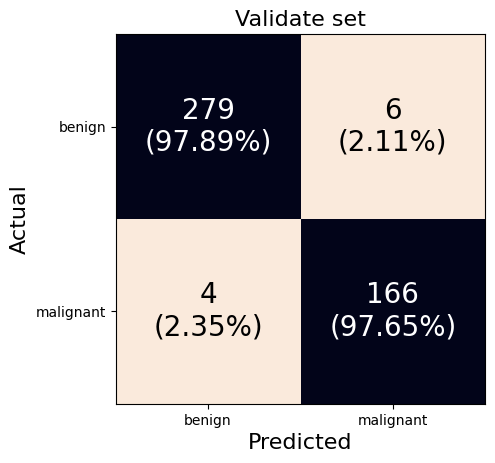

AUC1: 9927.76 ± 68.06%


In [107]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)
Mean_SD("AUC1",param4_split1_AUC_val*100, param4_split2_AUC_val*100, param4_split3_AUC_val*100, param4_split4_AUC_val*100, param4_split5_AUC_val*100)

## param5

param5
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%

split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 95.88 ± 3.35%
specificity: 98.95 ± 0.96%
accuracy: 97.80 ± 1.35%
precision: 98.22 ± 1.63%
f1_score: 97.00 ± 1.86%


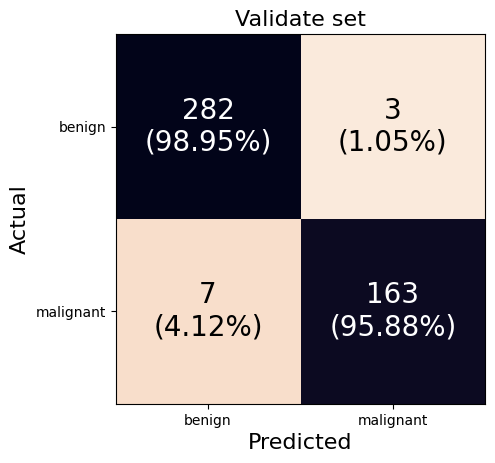

AUC1: 9924.66 ± 80.57%


In [108]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param5_split1_AUC_val*100, param5_split2_AUC_val*100, param5_split3_AUC_val*100, param5_split4_AUC_val*100, param5_split5_AUC_val*100)

In [29]:
def predict_set(split,param):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    
    loaded_model = joblib.load("../SGD/models/param{}/sgd_model_{}.pkl".format(param,split))
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    return y_val, y_pred_val, y_pred_val_raw
def ROC_split(param):
    split = "split1"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split2"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc2 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split3"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr3, tpr3, thr3 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc3 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split4"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr4, tpr4, thr4 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc4 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split5"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr5, tpr5, thr5 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc5 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc3)
    print("AUC split4: %.2f%%" % auc4)
    print("AUC split5: %.2f%%" % auc5)
    
    plt.plot(fpr1,tpr1,label="ROC split 1, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC split 2, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr3,tpr3,label="ROC split 3, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr4,tpr4,label="ROC split 4, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr5,tpr5,label="ROC split 5, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()


../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.463268
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.330000
FPR: 0.0526
TPR: 0.9706
../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.435132
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M'

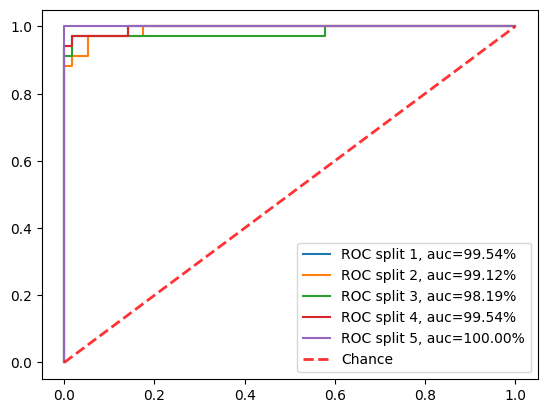

In [30]:
ROC_split(4)

# Test best param

In [23]:
train_path = "../kitt/DATA_progress3_new/train.csv"
test_path = "../kitt/DATA_progress3_new/test.csv"

In [24]:
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the test se
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(455, 18)
(455, 16)
['B' 'M']
(114, 18)
(114, 16)
['B' 'M']


In [25]:
model = SGDClassifier(loss='log_loss', penalty='l2', learning_rate='optimal', eta0=0.01, max_iter=1000, alpha=0.01)
model.fit(x_train, y_train)# Save the trained model to disk
joblib.dump(model, "../SGD/models/sgd_model_all.pkl")

['../SGD/models/sgd_model_all.pkl']

../SGD/models/sgd_model_all.pkl
################# test set ##################
Best Threshold=0.417140
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


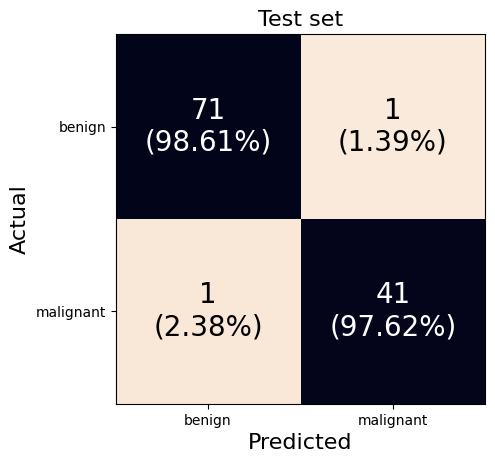

---------------------------------------
AUC test: 99.70%


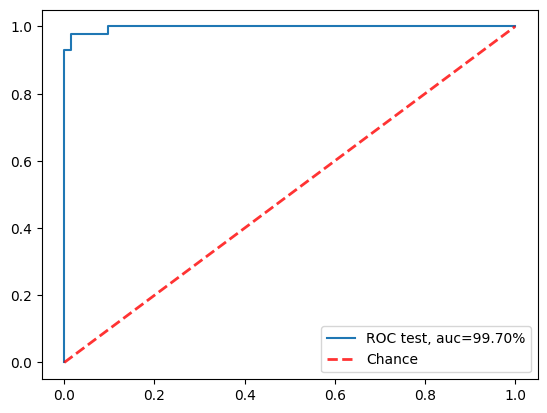

################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
2    8810158         B         22.54      529.4           0.1002   
110   889403         M         19.38      758.6           0.0784   

     concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
2           0.08705         0.1850                 0.07310      0.9223   
110         0.04209         0.1547                 0.05443      0.9988   

     area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
2      15.09       0.005251       0.02526      0.02514              0.004198   
110    22.18       0.002826       0.01311      0.01013              0.001345   

     smoothness_worst  concavity_worst  symmetry_worst  \
2              0.1349           0.3162          0.4128   
110            0.1084           0.2260          0.2683   

     fractal_dimension_worst  
2                    0.10760  
110                  0.06829  
[2, 110]


In [28]:
model_path = "../SGD/models/sgd_model_all.pkl"
print(model_path)
loaded_model = joblib.load(model_path)

# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
# print(split)
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test,which="Test set")

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()


print("################# false predict ##################")

false_indices = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_test[i]:
        false_indices.append(i)
print(test_data.loc[false_indices])
print(false_indices)